In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime

from arch import arch_model
from scipy.stats import norm

from tqdm import tqdm

In [3]:
def get_data(symbol, risk_free, volatility_proxy, time_period):
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=time_period * 252)

    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['log_returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    stock_data.dropna(subset=['log_returns'], inplace=True)

    risk_free_data = yf.download(risk_free, start=start_date, end=end_date)[['Close']] / 100
    risk_free_data.columns = ["Rate"]

    volatility_proxy_data = yf.download(volatility_proxy, start=start_date, end=end_date)[['Close']]
    volatility_proxy_data.columns = ['Vol_Proxy']

    volatility_proxy_data.loc[:, 'implied_volatility'] = volatility_proxy_data['Vol_Proxy'] / 100.0

    data = pd.merge(stock_data, risk_free_data, how='left', on='Date')
    data = pd.merge(data, volatility_proxy_data[['implied_volatility']], how='left', on='Date')

    data.ffill(inplace=True)


    ##### ESTIMATE VOLATILITY OF STOCK WITH GARCH MOODEL #####
    garch_model = arch_model(data['log_returns'] * 100, vol='Garch', p=1, q=1, mean='Zero', dist='normal')
    garch_fit = garch_model.fit(disp="off")
    data['volatility'] = garch_fit.conditional_volatility
    data['annualized_volatility'] = data['volatility'] * np.sqrt(252) / 100
    data['smoothed_annualized_volatility'] = data['annualized_volatility'].rolling(window=3, min_periods=1).mean()
    data.dropna(subset='smoothed_annualized_volatility', inplace=True)


    plt.figure(figsize=(10, 12))
    plt.subplot(3, 1, 1)
    plt.plot(data.index, data['Close'], label=f"{symbol}", color='blue')
    plt.title(f"{symbol} Price")

    plt.subplot(3, 1, 2)
    plt.plot(data.index, data['implied_volatility'], label=f"Implied Vol ({volatility_proxy}-based)", color='red')
    plt.plot(data.index, data['annualized_volatility'], label="GARCH Estimated Annual Vol", ls="--", alpha=0.5)
    plt.title(f"Volatilities ({volatility_proxy} and GARCH)")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(data.index, data['Rate'], label="Risk Free Rate", color='black')
    plt.title("Risk Free Rate")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return data

In [4]:
def compute_d1_d2(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

def black_scholes(S, K, T, r=0.02, sigma=0.2, option_type='call'):
    d1, d2 = compute_d1_d2(S, K, r=r, sigma=sigma, T=T)
    if option_type == 'call':
        c = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put': 
        c = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Error, option must be of type 'call' or 'put'")
    return c, norm.cdf(d1)

def value_bank(S, N_s, C, N_c):
    bank = -N_c*C + (-N_s)*S
    return bank

def build_initial_positions(data, r=0.02, fees=1/1000, K_multiplier=1.1, use_vix_proxy=False):
    S0 = data['Close'].iloc[0]
    K = int(round(K_multiplier * S0, -1))
    if use_vix_proxy:
        g = data['implied_volatility'].iloc[0]
    else:
        g = data['annualized_volatility'].iloc[0]
    r = data['Rate'].iloc[0]
    N_call = 1
    T = 6/12

    call_price, call_delta = black_scholes(S0, K, T, r, g, 'call')
    shares = -N_call * call_delta
    bank = (-N_call * call_price) + ((-shares) * S0)
    initial_fees = (N_call * call_price + abs(shares * S0)) * fees
    bank -= initial_fees
    value_portfolio = bank + (shares * S0) + (N_call * call_price)

    return {
        "S": S0,
        "K": K,
        "Volatility": g,
        "Risk Free": r, 
        "Shares": shares,
        "Option_Type": 'call',
        "Option_Price": call_price,
        "Option_Delta": call_delta,
        "Bank": bank,
        "Value_portfolio": value_portfolio,
        "fees_cumsum": initial_fees,
        "fees_transaction": initial_fees
    }

def simulate_trades(data, initial_positions, fees=1/1000, day_rebalancing=1, day_rolling=21, K_multiplier=1.1, use_vix_proxy=False):
    portfolio = {}
    position = initial_positions.copy()
    cumulative_drift = 0  
    portfolio[data.index[0]] = position
    N_call = 1 

    for i in tqdm(range(day_rebalancing, len(data), day_rebalancing)):
        prev_position = portfolio[data.index[i - day_rebalancing]].copy()
        S = data['Close'].iloc[i]
        if use_vix_proxy:
            g = data['implied_volatility'].iloc[i]
        else:
            g = data['smoothed_annualized_volatility'].iloc[i]
        r = data['Rate'].iloc[i]

        days_elapsed = i
        T = 0.5 - (days_elapsed / 252)
        if T <= 0:
            T = 1/252

        rolling_costs = 0
        if i % day_rolling == 0:
            T = 0.5
            K = int(round(K_multiplier * S, -1))
        else:
            K = prev_position['K']

        call_price, call_delta = black_scholes(S, K, T, r, g, 'call')

        bank = prev_position['Bank'] * np.exp(r * (day_rebalancing / 252))

        if i % day_rolling == 0:
            bank += prev_position['Option_Price']
            bank -= call_price
            rolling_costs = fees * (prev_position['Option_Price'] + call_price)
            bank -= rolling_costs

        shares_old = prev_position['Shares']
        shares_new = -N_call * call_delta
        shares_change = shares_new - shares_old

        transaction_fee = abs(shares_change * S) * fees
        bank -= transaction_fee
        bank -= (shares_change * S)

        fees_cumsum = prev_position['fees_cumsum'] + transaction_fee + rolling_costs

        value_stock = shares_new * S
        value_portfolio = bank + value_stock + (N_call * call_price)

        total_delta = call_delta + (value_stock / S)
        if abs(total_delta) > 1e-6:
            print(f"WARNING: Portfolio not delta-neutral on Day {data.index[i]}. Total Delta: {total_delta:.6f}")

        cumulative_drift += abs(total_delta)

        new_position = {
            "S": S,
            "K": K,
            "Volatility": g,
            "Risk Free": r,
            "Shares": shares_new,
            "Option_Type": 'call',
            "Option_Price": call_price,
            "Option_Delta": call_delta,
            "Bank": bank,
            "Value_portfolio": value_portfolio,
            "fees_transaction": transaction_fee + rolling_costs,
            "fees_cumsum": fees_cumsum,
            "Cumulative_Delta_Drift": cumulative_drift
        }

        portfolio[data.index[i]] = new_position

    results = pd.DataFrame(portfolio).T
    return results

In [5]:
def plot_hedged_portfolio(portfolio_data):
    print("----- Simulation Summary -----")
    if 'Value_portfolio' in portfolio_data.columns:
        print(f"Total Portfolio Value: ${portfolio_data['Value_portfolio'].iloc[-1]:.2f}")
    if 'fees_cumsum' in portfolio_data.columns:
        print(f"Total Cumulative Fees: ${portfolio_data['fees_cumsum'].iloc[-1]:.2f}")
    if 'Cumulative_Delta_Drift' in portfolio_data.columns:
        print(f"Total Cumulative Delta Drift: {portfolio_data['Cumulative_Delta_Drift'].iloc[-1]:.6f}")

    fig1, ax1 = plt.subplots(figsize=(12, 6))

    if 'S' in portfolio_data.columns:
        ax1.plot(portfolio_data['Date'], portfolio_data['S'], label='Stock Price', color='blue')
    if 'K' in portfolio_data.columns:
        ax1.plot(portfolio_data['Date'], portfolio_data['K'], label='Strike Price', color='black', linestyle='--')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('Stock Price, Strike Price, and Volatility Over Time', fontsize=16)

    if 'Volatility' in portfolio_data.columns:
        ax2 = ax1.twinx()
        ax2.plot(portfolio_data['Date'], portfolio_data['Volatility'], label='Volatility', color='green')
        ax2.set_ylabel('Volatility', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    else:
        ax1.legend(loc='upper left')

    fig1.tight_layout()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    if 'Value_portfolio' in portfolio_data.columns:
        fig2, ax = plt.subplots(figsize=(12, 6))
        ax.plot(portfolio_data['Date'], portfolio_data['Value_portfolio'], label='Portfolio Value', color='green')
        ax.set_title('Portfolio Value Over Time', fontsize=16)
        ax.set_xlabel('Date')
        ax.set_ylabel('Value ($)', color='green')
        ax.tick_params(axis='y', labelcolor='green')
        ax.legend(loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(True)
        fig2.tight_layout()
        plt.show()

    if 'fees_cumsum' in portfolio_data.columns or 'Cumulative_Delta_Drift' in portfolio_data.columns:
        fig3, ax1 = plt.subplots(figsize=(12, 6))

        if 'fees_cumsum' in portfolio_data.columns:
            ax1.plot(portfolio_data['Date'], portfolio_data['fees_cumsum'], label='Cumulative Fees', color='red')
            ax1.set_ylabel('Fees ($)', color='red')
            ax1.tick_params(axis='y', labelcolor='red')
        else:
            ax1.set_ylabel('Fees ($)', color='red')
            ax1.tick_params(axis='y', labelcolor='red')

        ax1.set_xlabel('Date')
        ax1.set_title('Cumulative Fees and Delta Drift Over Time', fontsize=16)

        if 'Cumulative_Delta_Drift' in portfolio_data.columns:
            ax2 = ax1.twinx()
            ax2.plot(portfolio_data['Date'], portfolio_data['Cumulative_Delta_Drift'], label='Cumulative Delta Drift', color='orange')
            ax2.set_ylabel('Delta Drift', color='orange')
            ax2.tick_params(axis='y', labelcolor='orange')

            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            ax1.legend(lines_1, labels_1, loc='upper left')

        fig3.tight_layout()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    gamma_hedge = ('Option_Call_Price' in portfolio_data.columns and 
                   'Option_Put_Price' in portfolio_data.columns)

    if gamma_hedge:
        fig4, ax1 = plt.subplots(figsize=(12, 6))
        ax1.plot(portfolio_data['Date'], portfolio_data['Option_Call_Price'], label='Call Price', color='purple')
        ax1.plot(portfolio_data['Date'], portfolio_data['Option_Put_Price'], label='Put Price', color='magenta')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Option Prices', color='purple')
        ax1.tick_params(axis='y', labelcolor='purple')
        ax1.set_title('Option Prices and Deltas (Gamma Hedge)', fontsize=16)

        ax2 = ax1.twinx()
        if 'Option_Call_Delta' in portfolio_data.columns and 'Option_Put_Delta' in portfolio_data.columns:
            ax2.plot(portfolio_data['Date'], portfolio_data['Option_Call_Delta'], label='Call Delta', color='blue')
            ax2.plot(portfolio_data['Date'], portfolio_data['Option_Put_Delta'], label='Put Delta', color='cyan')
        ax2.set_ylabel('Delta', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

        fig4.tight_layout()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    else:
        if 'Option_Price' in portfolio_data.columns and 'Option_Delta' in portfolio_data.columns:
            fig4, ax1 = plt.subplots(figsize=(12, 6))

            ax1.plot(portfolio_data['Date'], portfolio_data['Option_Price'], label='Option Price', color='purple')
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Option Price', color='purple')
            ax1.tick_params(axis='y', labelcolor='purple')
            ax1.set_title('Option Price and Delta (Delta Hedge)', fontsize=16)

            ax2 = ax1.twinx()
            ax2.plot(portfolio_data['Date'], portfolio_data['Option_Delta'], label='Option Delta', color='blue')
            ax2.set_ylabel('Delta', color='blue')
            ax2.tick_params(axis='y', labelcolor='blue')

            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

            fig4.tight_layout()
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\vince\AppData\Local\Temp\ipykernel_4804\5201043.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volatility_proxy_data.loc[:, 'implied_volatility'] = volatility_proxy_data['Vol_Proxy'] / 100.0


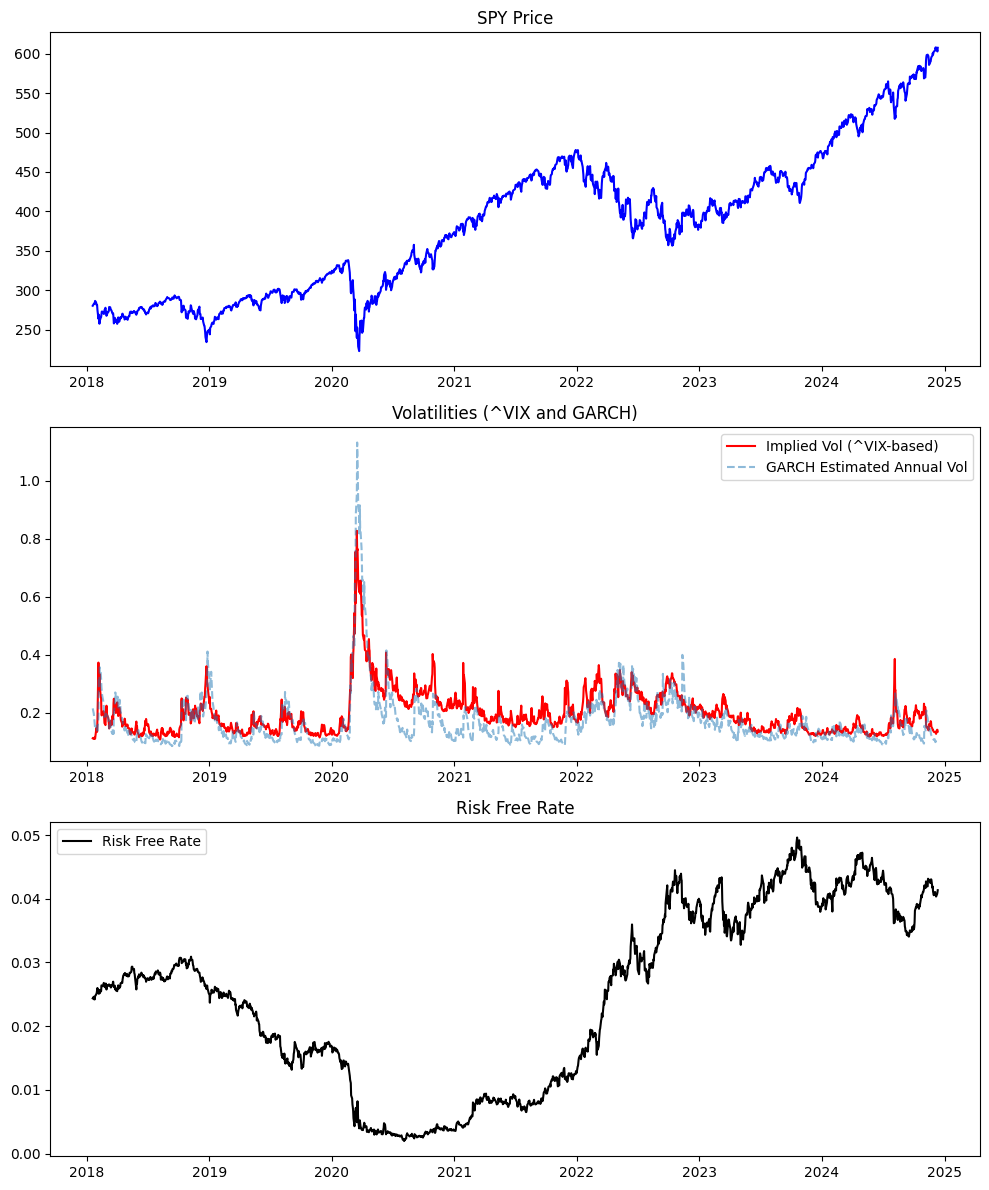

100%|██████████| 1735/1735 [00:00<00:00, 3560.87it/s]


----- Simulation Summary -----
Total Portfolio Value: $-191.89
Total Cumulative Fees: $124.13
Total Cumulative Delta Drift: 0.000000


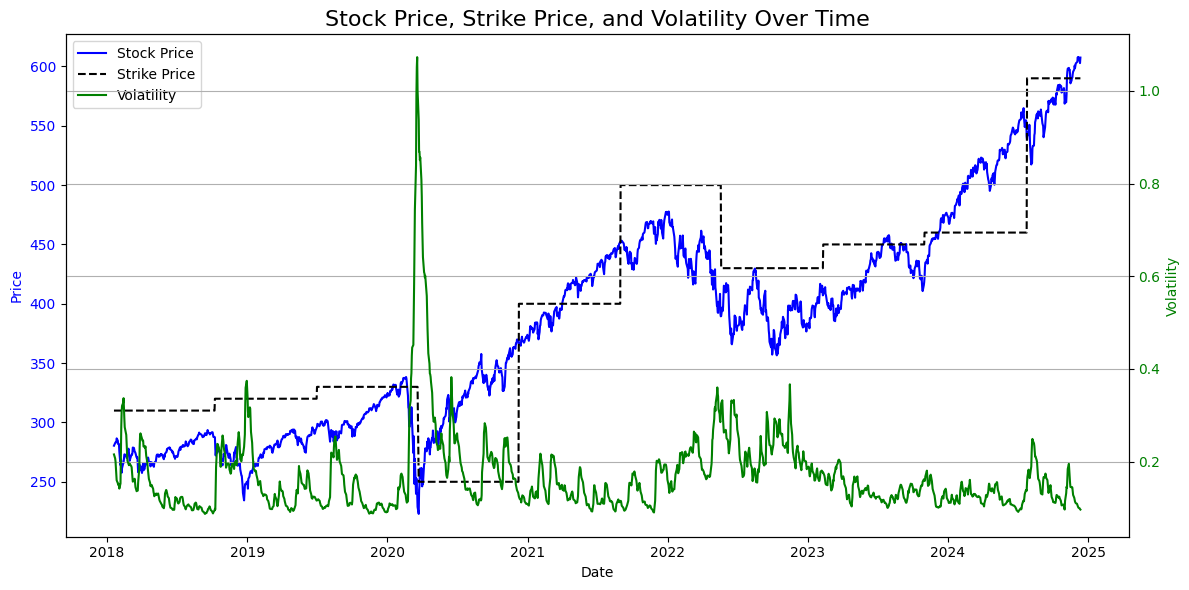

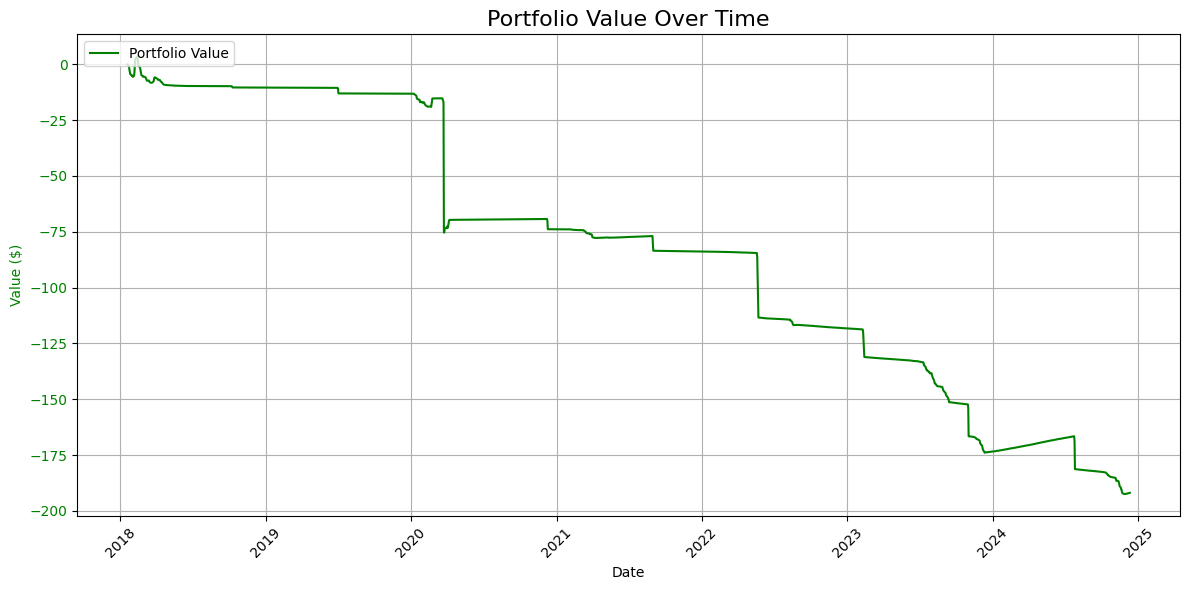

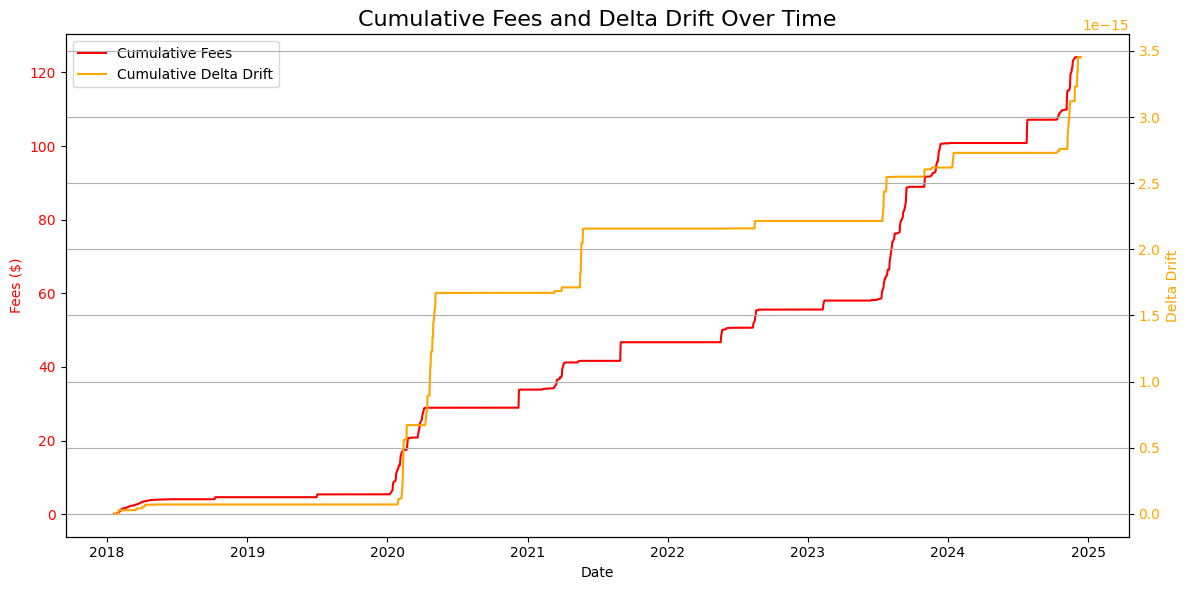

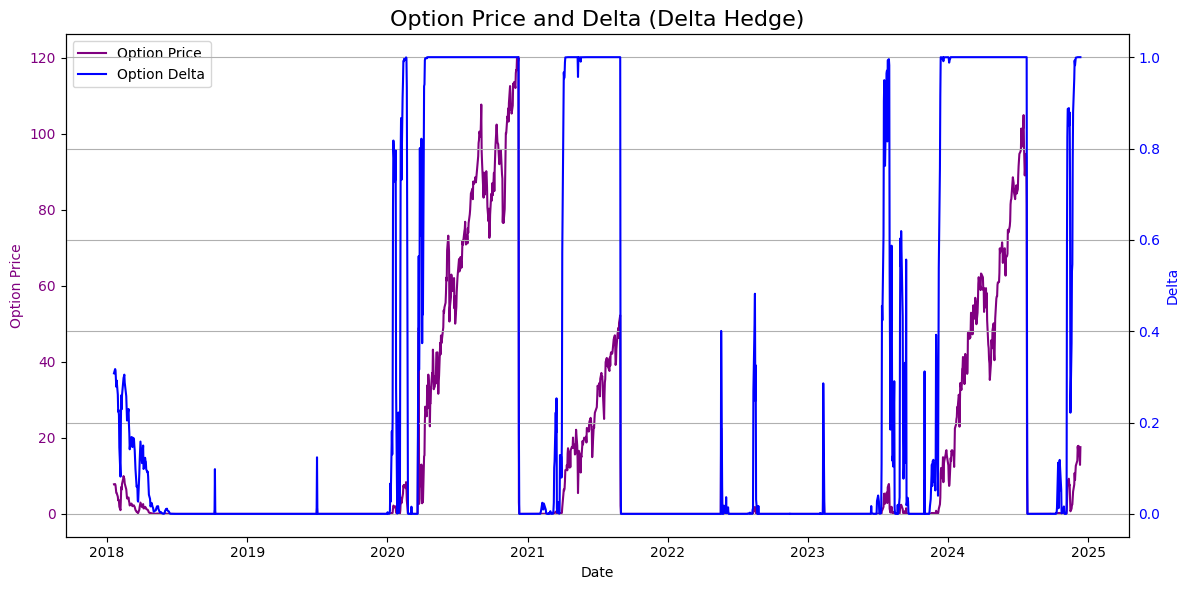

----- Simulation Summary -----
Total Portfolio Value: $-187.82
Total Cumulative Fees: $130.48
Total Cumulative Delta Drift: 0.000000


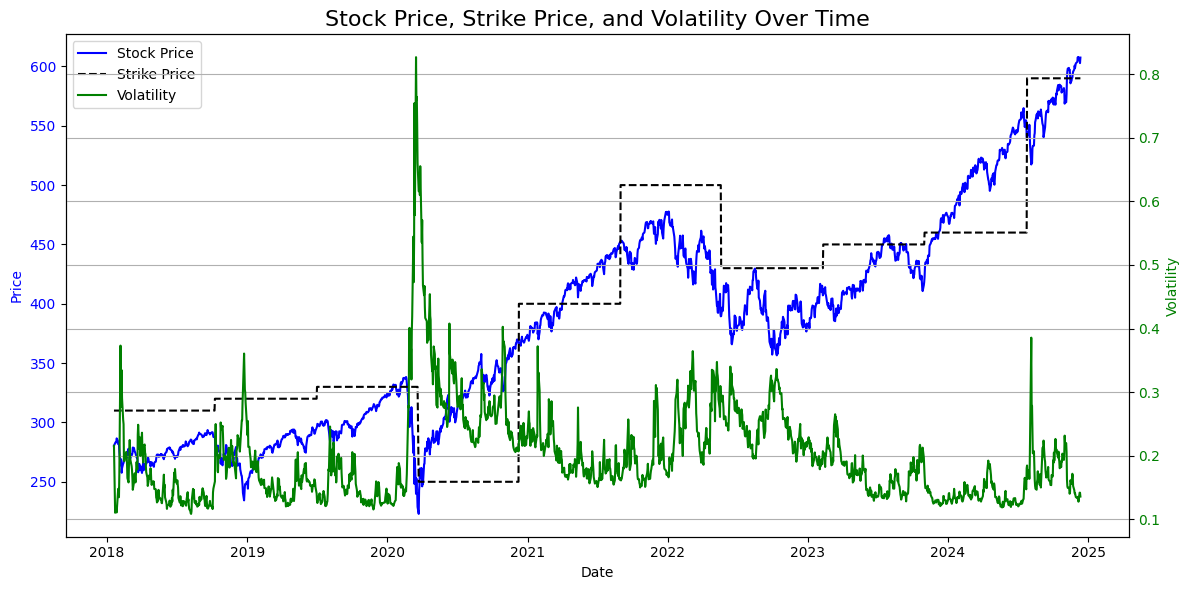

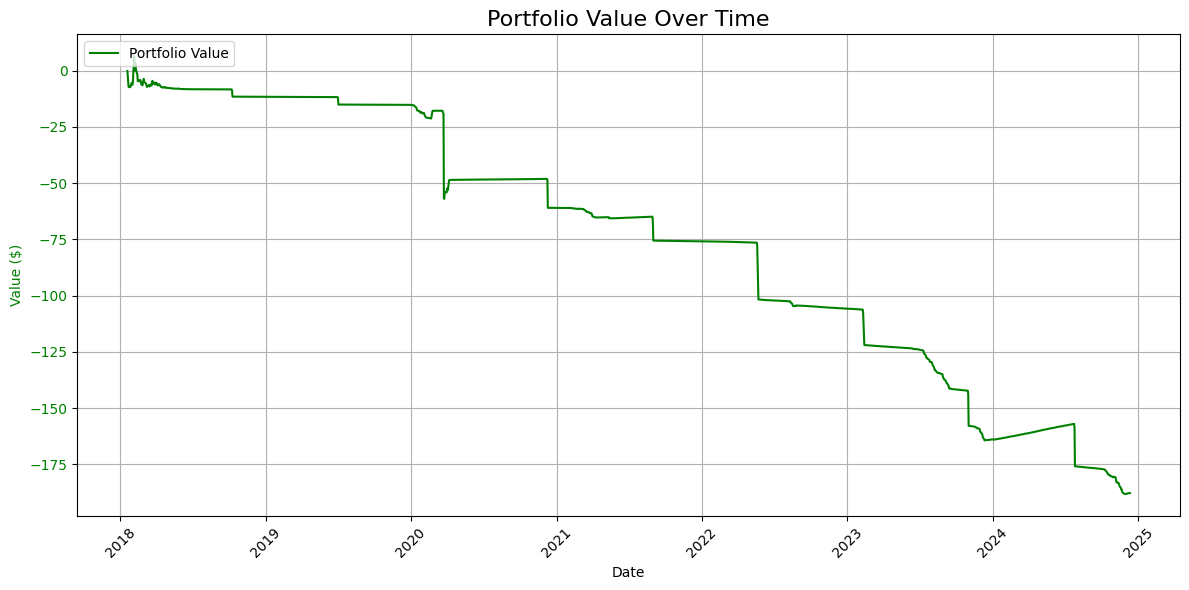

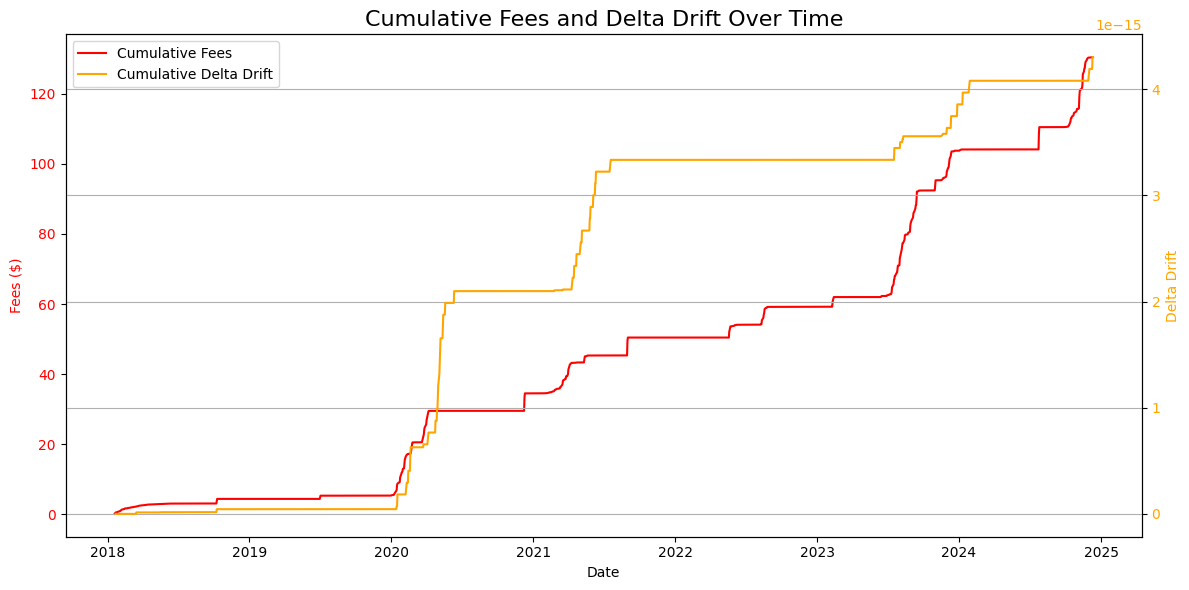

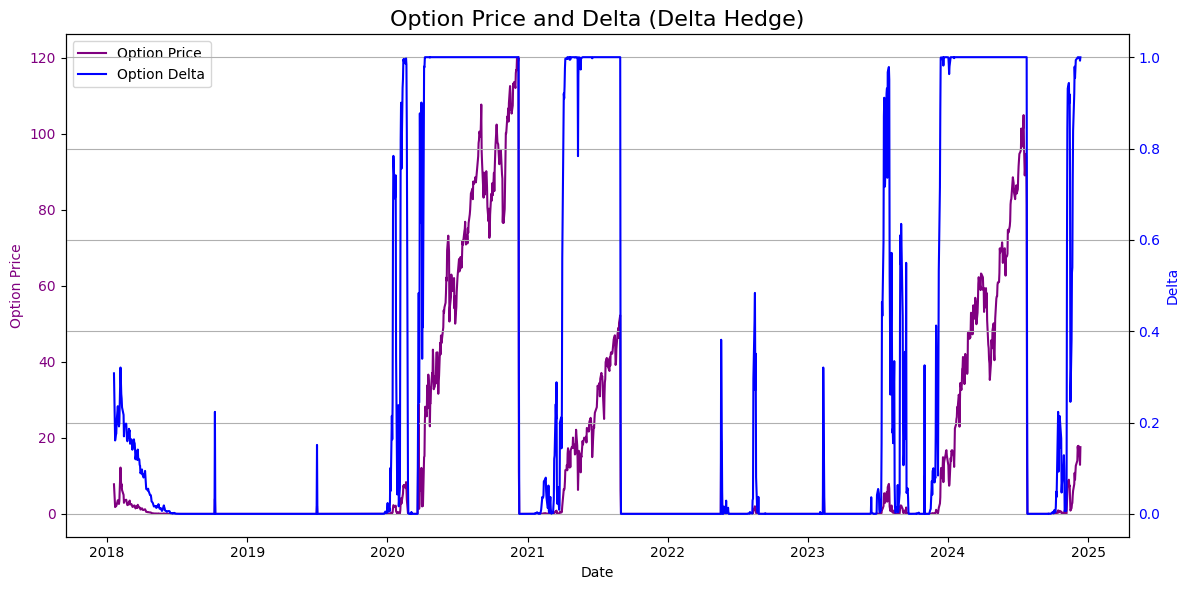

In [22]:
symbol = "SPY"
risk_free = '^FVX'  
vix_symbol = '^VIX'
year_history = 10

data = get_data(symbol=symbol, risk_free=risk_free, volatility_proxy=vix_symbol, time_period=year_history)


day_stock = 1
day_option = 365//2


initial_positions_delta_hedged_garch = build_initial_positions(data=data)
portfolio_data_delta_hedged_garch = simulate_trades(data, 
                                              initial_positions_delta_hedged_garch, 
                                              fees=1/100, 
                                              day_rebalancing=day_stock, 
                                              day_rolling=day_option, 
                                              use_vix_proxy=False)

initial_positions_delta_hedged_vix = build_initial_positions(data=data)
portfolio_data_delta_hedged_vix = simulate_trades(data, 
                                              initial_positions_delta_hedged_vix, 
                                              fees=1/100, 
                                              day_rebalancing=day_stock, 
                                              day_rolling=day_option, 
                                              use_vix_proxy=True)


portfolio_data_delta_hedged_garch['Date'] = pd.to_datetime(portfolio_data_delta_hedged_garch.index)
portfolio_data_delta_hedged_garch.to_csv("portfolio_data_delta_hedged_garch.csv", index=False)
plot_hedged_portfolio(portfolio_data_delta_hedged_garch)

portfolio_data_delta_hedged_vix['Date'] = pd.to_datetime(portfolio_data_delta_hedged_vix.index)
portfolio_data_delta_hedged_vix.to_csv("portfolio_data_delta_hedged_vix.csv", index=False)
plot_hedged_portfolio(portfolio_data_delta_hedged_vix)

In [23]:
def parameter_sweep(data, day_stock_values, day_option_values, fees=1/100, K_multiplier=1.1, use_vix_proxy=False):
    results = []
    
    for day_stock in tqdm(day_stock_values, desc="Day Stock Iteration"):
        for day_option in day_option_values:
            initial_positions = build_initial_positions(
                data=data,
                fees=fees,
                K_multiplier=K_multiplier,
                use_vix_proxy=use_vix_proxy
            )
            
            portfolio = simulate_trades(
                data=data, 
                initial_positions=initial_positions, 
                fees=fees, 
                day_rebalancing=day_stock, 
                day_rolling=day_option, 
                K_multiplier=K_multiplier, 
                use_vix_proxy=use_vix_proxy
            )
            
            final_value = portfolio['Value_portfolio'].iloc[-1]
            results.append({
                "day_stock": day_stock,
                "day_option": day_option,
                "final_portfolio_value": final_value
            })
    
    results_df = pd.DataFrame(results)
    return results_df


day_stock_values = range(1, 365, 21)      
day_option_values = range(1, 365, 21)  

print("Running parameter sweep for GARCH-based volatility...")
results_garch = parameter_sweep(
    data=data,
    day_stock_values=day_stock_values,
    day_option_values=day_option_values,
    fees=1/100,
    K_multiplier=1.1,
    use_vix_proxy=False
)

print("Running parameter sweep for VIX-based volatility...")
results_vix = parameter_sweep(
    data=data,
    day_stock_values=day_stock_values,
    day_option_values=day_option_values,
    fees=1/100,
    K_multiplier=1.1,
    use_vix_proxy=True
)

results_garch.to_csv("parameter_sweep_results_garch.csv", index=False)
results_vix.to_csv("parameter_sweep_results_vix.csv", index=False)

Running parameter sweep for GARCH-based volatility...


Day Stock Iteration: 100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


Running parameter sweep for VIX-based volatility...


Day Stock Iteration: 100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


C:\Users\vince\AppData\Local\Temp\ipykernel_4804\3659288211.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data_garch = results_garch.pivot("day_stock", "day_option", "final_portfolio_value")
C:\Users\vince\AppData\Local\Temp\ipykernel_4804\3659288211.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data_vix = results_vix.pivot("day_stock", "day_option", "final_portfolio_value")


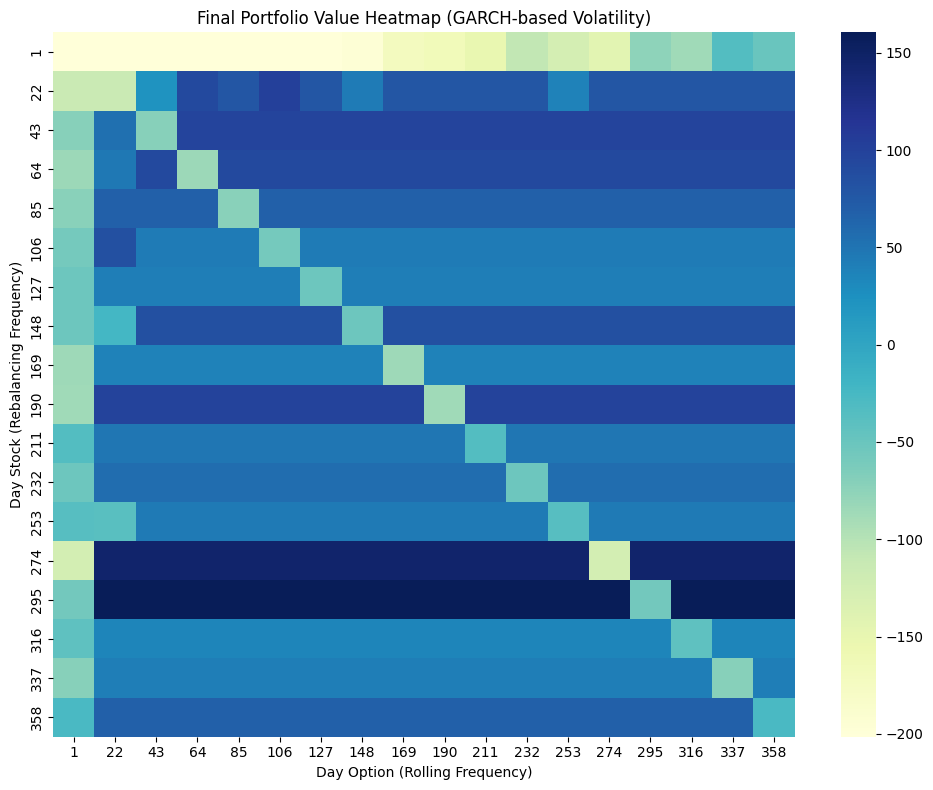

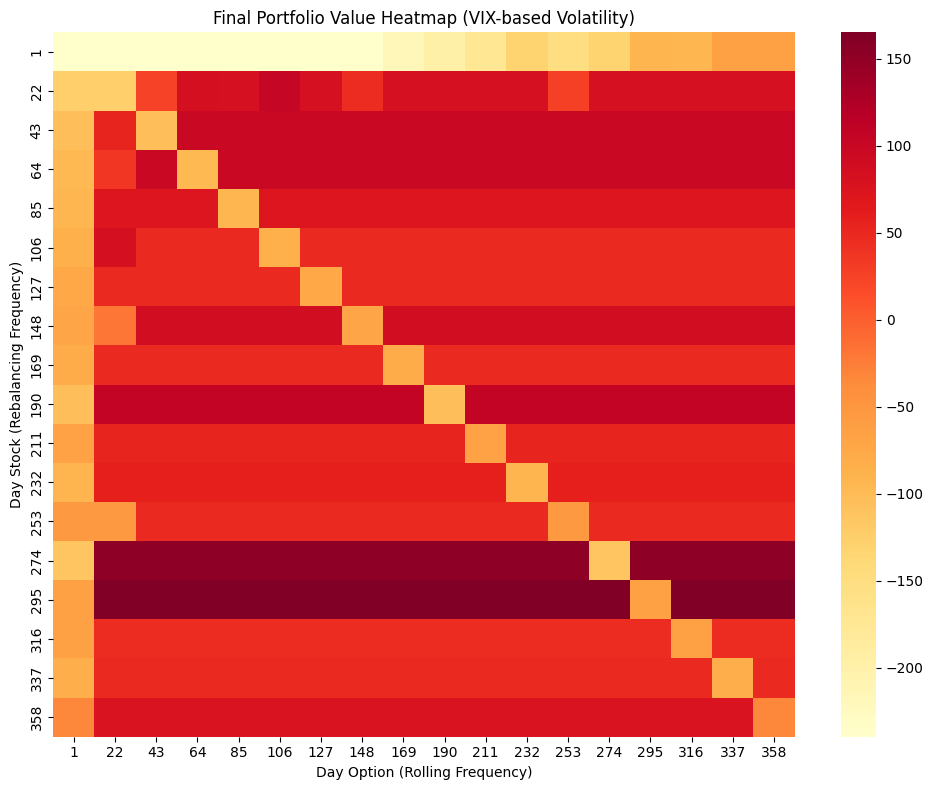

In [ ]:
results_garch = pd.read_csv("parameter_sweep_results_garch.csv")
results_vix = pd.read_csv("parameter_sweep_results_vix.csv")

heatmap_data_garch = results_garch.pivot("day_stock", "day_option", "final_portfolio_value")
heatmap_data_vix = results_vix.pivot("day_stock", "day_option", "final_portfolio_value")

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_garch, annot=False, fmt=".2f", cmap="YlGnBu", robust=True)
plt.title("Final Portfolio Value Heatmap (GARCH-based Volatility)")
plt.xlabel("Day Option (Rolling Frequency)")
plt.ylabel("Day Stock (Rebalancing Frequency)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_vix, annot=False, fmt=".2f", cmap="YlOrRd", robust=True)
plt.title("Final Portfolio Value Heatmap (VIX-based Volatility)")
plt.xlabel("Day Option (Rolling Frequency)")
plt.ylabel("Day Stock (Rebalancing Frequency)")
plt.tight_layout()
plt.show()